# Clean up the full train and test datasets

In [55]:
%matplotlib inline

In [89]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import pprint
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVR
from sklearn import model_selection

## Load Data

In [57]:
train_file = "../data/train.csv"
train_orig = pd.read_csv(train_file, index_col=0)
train = train_orig.copy()

test_file = "../data/test.csv"
test_orig = pd.read_csv(test_file, index_col=0)
test = test_orig.copy()


## Clean the data

### Some manual data cleaning based on experience working with dataset.

In [58]:
# There is only one train record that isn't "Utilities=AllPub"...
train.drop(['Utilities'], inplace=True, axis=1)
test.drop(['Utilities'], inplace=True, axis=1)

In [59]:
# There is a single MSSubClass==150 in test and none in train.
# From the description, we know:
#       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#       150	1-1/2 STORY PUD - ALL AGES
#       160	2-STORY PUD - 1946 & NEWER
# 120 is more common than 150, and although 1.5 story makes sense to be worth more than 1 story, all ages might be worth less...
# Sort of arbitrarily set 150->120
train.loc[train['MSSubClass'] == 150, 'MSSubClass'] = 120 # Just for symmetry - this doesn't actually match any records
test.loc[test['MSSubClass'] == 150, 'MSSubClass'] = 120

In [60]:
# Very few RRNe and RRNn.  Combine them with similar records.  
train.loc[train['Condition1'] == 'RRNe', 'Condition1'] = 'RRAe'
train.loc[train['Condition1'] == 'RRNn', 'Condition1'] = 'RRAn'
test.loc[test['Condition1'] == 'RRNe', 'Condition1'] = 'RRAe'
test.loc[test['Condition1'] == 'RRNn', 'Condition1'] = 'RRAn'

# Condition2 is overflow from condition1.  
# Really I should combine Condition1 and Condition2 when I do the one-hot's below, but instead I'll just skip...
train.drop(['Condition2'], inplace=True, axis=1)
test.drop(['Condition2'], inplace=True, axis=1)


In [61]:
# Only one mix.  Assume it is similar to SBrkr
train.loc[train['Electrical'] == 'Mix', 'Electrical'] = 'SBrkr'
test.loc[test['Electrical'] == 'Mix', 'Electrical'] = 'SBrkr'

In [62]:
# 2.5fin is only in the training data.  Assume it is similar to 2Story
train.loc[train['HouseStyle'] == '2.5Fin', 'HouseStyle'] = '2Story'
test.loc[test['HouseStyle'] == '2.5Fin', 'HouseStyle'] = '2Story'

### Impute the numeric data

In [64]:
cols_numeric = train.select_dtypes(include=[np.number]).columns.tolist()

# Don't want to impute on sale price...
cols_numeric.remove('SalePrice')

# Look down each column and replace missing values with the median of that column 
# (since we're using integers, median seemed to make more sense)
# Imputer is trained on the training data, NOT the test data!
imp_numeric = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_numeric.fit(train[cols_numeric])

# train_imputed = train.copy()
train[cols_numeric] = imp_numeric.transform(train[cols_numeric])
# test_imputed  = test.copy()
test[cols_numeric]  = imp_numeric.transform(test[cols_numeric])

### Handle the non-numeric columns

### sklearn has OneHotEncoder, but pandas now has a built in get_dummies()
see:
* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
* http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

Make an imputer for categoricals.  Inherrit the TransformerMixin for .fit and .transform

In [65]:
class CategoricalImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing categorical values by replacing them with the most common value.
        
        Adapted from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        """
        
    def fit(self, X, y=None):
        # Make a pd.Series that has a fill value for each column (use np.nan for anything non-categorical)
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else np.nan for c in X ], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
# Example:

# data = [
#     ['a', 1, 2],
#     ['b', 1, 1],
#     ['b', 2, 2],
#     [np.nan, np.nan, np.nan]
# ]

# X = pd.DataFrame(data)
# xt = CategoricalImputer().fit_transform(X)

# print('before...')
# print(X)
# print('after...')
# print(xt)

Get the non-numeric columns


In [66]:
cols_non_numeric = train.select_dtypes(exclude=[np.number]).columns.tolist()


Many columns have nan, but from the description several use nan as a value.  Only fix the ones that shouldn't have nan

In [67]:
# Make lists for datasets that could intentionally have nan (typically they mean "I don't have this feature")
# Any record with a nan in a basement category should have a nan in all basement categories.  Same with garage.  
# Groupd those to check
nan_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
nan_garage = ['GarageType', 'GarageQual', 'GarageFinish', 'GarageCond']
nan_intentional = ['Alley', 
                   'FireplaceQu', 
                   'PoolQC', 'Fence', 'MiscFeature',] + nan_bsmt + nan_garage

# Get the other nan's (this would have been easier to just type the unintentional ones, but I was already done listing the intentionals..)
# Need to get nan from both train and test.  Get them separately then combine by using sets
nan_unintentional_train = set([train[cols_non_numeric].iloc[:,x].name for x in pd.isnull(train[cols_non_numeric]).any().nonzero()[0] if train[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional_test = set([test[cols_non_numeric].iloc[:,x].name for x in pd.isnull(test[cols_non_numeric]).any().nonzero()[0] if test[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional = list(nan_unintentional_train) + list(nan_unintentional_test-nan_unintentional_train)

nan_rows_train = pd.isnull(train[nan_unintentional]).any(1).nonzero()[0]
nan_rows_train_byId = train.index[nan_rows_train]
nan_rows_test = pd.isnull(test[nan_unintentional]).any(1).nonzero()[0]
nan_rows_test_byId = test.index[nan_rows_test]

imp_categorical = CategoricalImputer()
imp_categorical.fit(train[nan_unintentional])
# train_imputed_categorical = train.copy()
train[nan_unintentional] = imp_categorical.transform(train[nan_unintentional])

# And same for test
test[nan_unintentional] = imp_categorical.transform(test[nan_unintentional])

## Formalize things a bit more

Make scalable code that can process and regress on more features

In [68]:
def feat_eng_polys(df, feat, pwrs, inplace=True):
    """
    Given a dataframe and a feature, return a new (add to existing?) dataframe new features that are the pwrs'th power of the feature.
    
    NOTE: inplace=True isn't entirely inplace.  It was giving me the "A value is trying to be set on a copy of a slice from a DataFrame" error.
    I couldn't figure out why it was happening (or whether it was a false positive), so
    instead i've just changed this to make df_new=df.copy() to work around it.
    
    :param pwrs:
        NOT IMPLEMENTED If pwrs=int, return all powers from 1 to that number.
        NOT IMPLEMENTED If pwrs=float, return that power.
        If pwrs=iterable, return the powers included in pwrs
    """
    f_new = []
    if inplace is not True:
        df_new = pd.DataFrame(index=df.index)
    else:
        df_new = df.copy()

    for p in pwrs:
        f_new.append('{:s}_{:s}'.format(feat, str(p)))
        df_new.loc[:, f_new[-1]] = df.loc[:, feat] ** p

    # Does it matter if this gets returned when doing inplace=True?
    return df_new, f_new

In [69]:
def get_RSS(d1, d2):
    """Return the sum of the square of the errors between two datasets, a measure of total error."""
    npa1 = np.asarray(d1)
    npa2 = np.asarray(d2)
    if npa1.shape != npa2.shape:
        raise ValueError("Found arrays of shape {} and {} - shape of arrays must be the same.".format(npa1.shape, npa2.shape))
    return ((np.asarray(d1) - np.asarray(d2)) ** 2).sum()
def get_RMS(d1, d2):
    """Return the RMS or standard deviation of error between two datasets, a measure of typical error."""
    npa1 = np.asarray(d1)
    npa2 = np.asarray(d2)
    if npa1.shape != npa2.shape:
        raise ValueError("Found arrays of shape {} and {} - shape of arrays must be the same.".format(npa1.shape, npa2.shape))
    return np.sqrt(((np.asarray(d1) - np.asarray(d2)) ** 2).mean())


In [70]:
def outliers_numerical(data, m=2.):
    """Return a boolean array of outliers given numerical data.
    
    Outliers are assessed given:
      m > (x-median(X)) / median(x-median(x))
    if their median(x-median(x)) != 0,
    eg: multiples of the typical distance from the median.
    
    If median(x-median(x)) == 0, mean(x-median(x)) is used as the normalizer:
      m > (x-median(X)) / mean(x-median(x))
    """
    d = np.abs(np.asarray(data) - np.median(np.asarray(data)))
    # Use median if possible, but if median comes out 0 then use mean as a fallback
    mdev = np.median(d)
    s = d/mdev if mdev else d/np.mean(d)
    return ~(s<m)

In [71]:
# Feature-generating code

def feature_TotLivSF(df):
    return df['GrLivArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2']

In [72]:
# Original base features to use (categorical and numerical separate?)
features = {'num': cols_numeric, #now using OverallQual as a number!
            'cat': cols_non_numeric,
           }

# Working copy of data
# data = {'train': train.loc[:, features['num'] + features['cat'] + ['SalePrice']].copy(),
#         'test': test.loc[:, features['num'] + features['cat']].copy()}
data = {'train': train.copy(),
        'test': test.copy()}


# Containers for added features
features_new = {'num': [],
                'cat': [],
               }

In [73]:
# Add TotLivSF numeric feature
def feature_TotLivSF(df):
    return df['GrLivArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2']

for k,d in data.items():
    d.loc[:, 'TotLivSF'] = feature_TotLivSF(d)
features['num'].append('TotLivSF')

print("All base features:")
pprint.pprint(features)

All base features:
{'cat': ['MSZoning',
         'Street',
         'Alley',
         'LotShape',
         'LandContour',
         'LotConfig',
         'LandSlope',
         'Neighborhood',
         'Condition1',
         'BldgType',
         'HouseStyle',
         'RoofStyle',
         'RoofMatl',
         'Exterior1st',
         'Exterior2nd',
         'MasVnrType',
         'ExterQual',
         'ExterCond',
         'Foundation',
         'BsmtQual',
         'BsmtCond',
         'BsmtExposure',
         'BsmtFinType1',
         'BsmtFinType2',
         'Heating',
         'HeatingQC',
         'CentralAir',
         'Electrical',
         'KitchenQual',
         'Functional',
         'FireplaceQu',
         'GarageType',
         'GarageFinish',
         'GarageQual',
         'GarageCond',
         'PavedDrive',
         'PoolQC',
         'Fence',
         'MiscFeature',
         'SaleType',
         'SaleCondition'],
 'num': ['MSSubClass',
         'LotFrontage',
         'Lo

In [74]:
# # Filter outliers from numerical data

# # Visualize the univariate and multivariate interactions for numeric data using a scatter_matrix
# print("Training data:")
# scatter_matrix(data['train'][features['num'] + ['SalePrice']])
# plt.show()
# print("Test data:")
# scatter_matrix(data['test'][features['num']])
# plt.show()


Total outliers = 539
Feature MSSubClass has 0 outliers


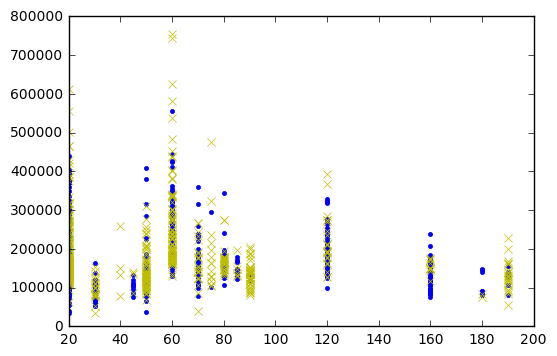

Feature LotFrontage has 18 outliers


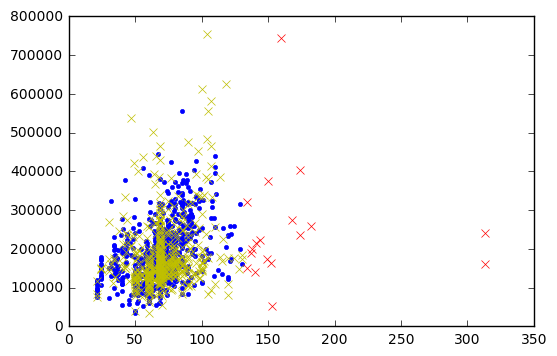

Feature LotArea has 35 outliers


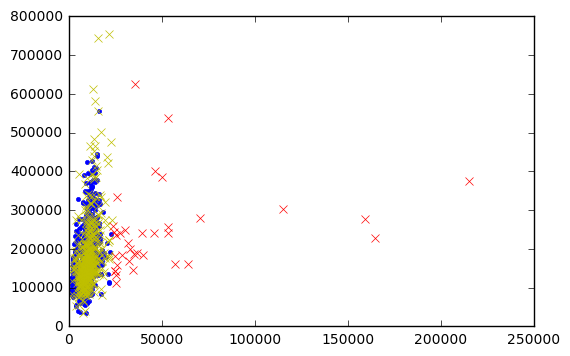

Feature OverallQual has 0 outliers


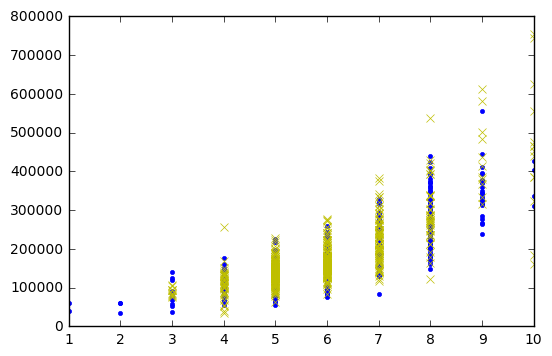

Feature OverallCond has 0 outliers


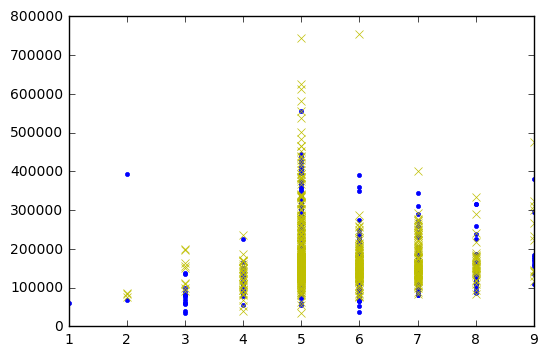

Feature YearBuilt has 0 outliers


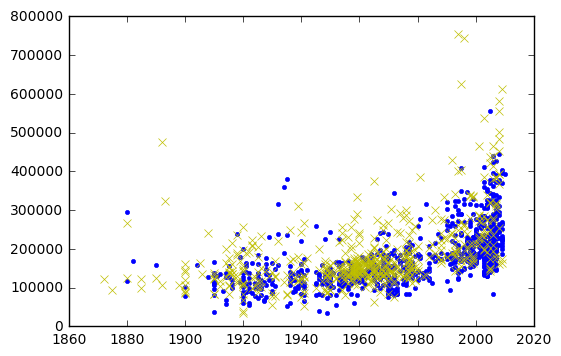

Feature YearRemodAdd has 0 outliers


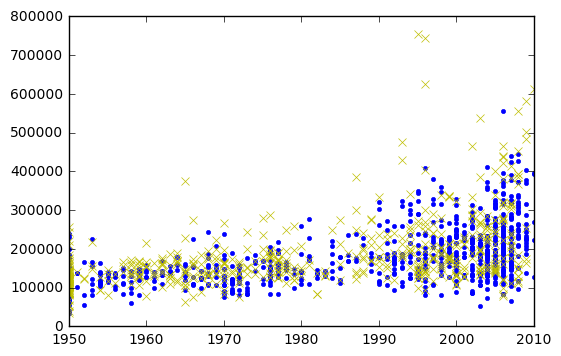

Feature MasVnrArea has 23 outliers


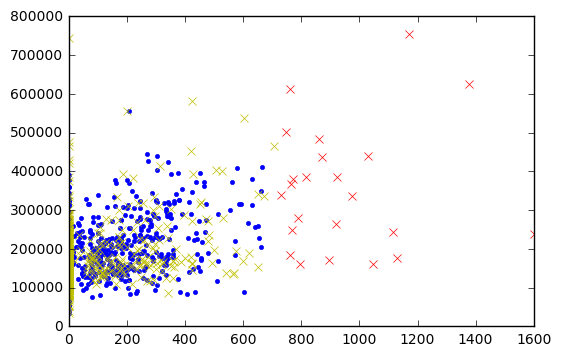

Feature BsmtFinSF1 has 1 outliers


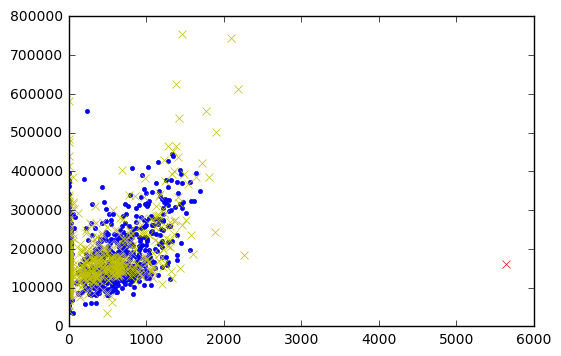

Feature BsmtFinSF2 has 89 outliers


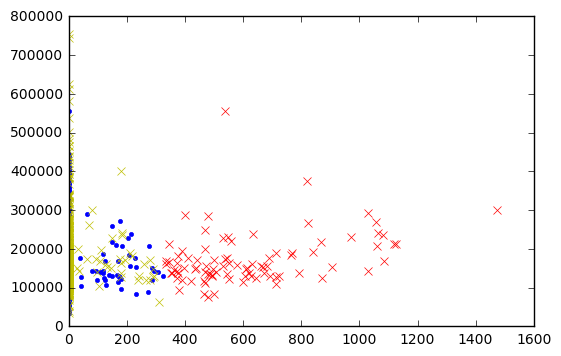

Feature BsmtUnfSF has 0 outliers


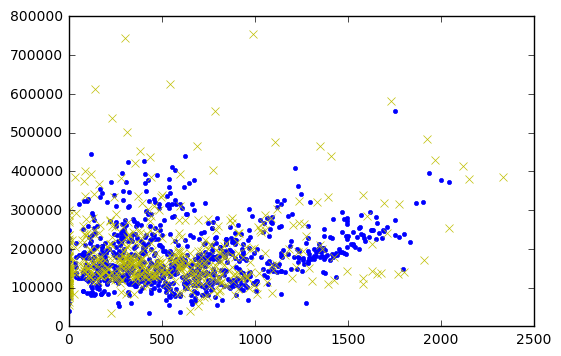

Feature TotalBsmtSF has 6 outliers


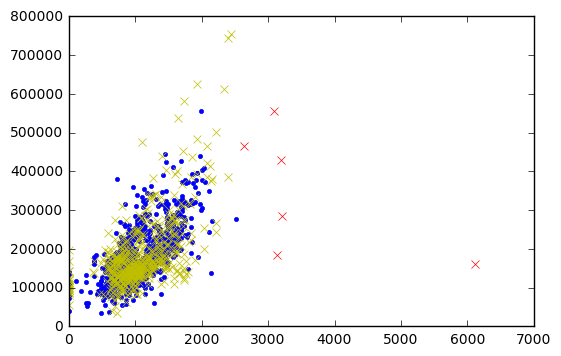

Feature 1stFlrSF has 4 outliers


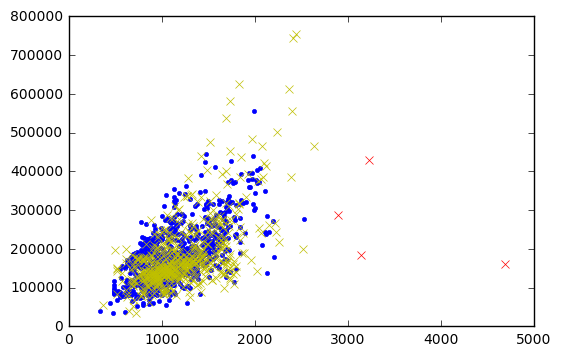

Feature 2ndFlrSF has 0 outliers


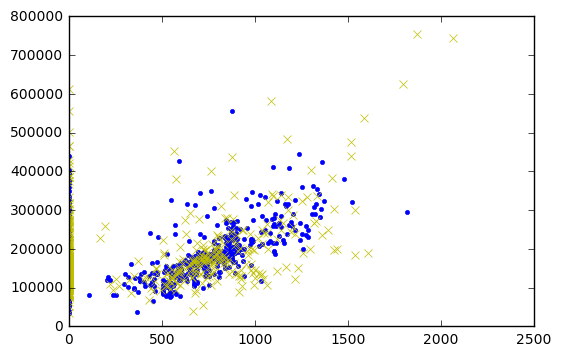

Feature LowQualFinSF has 26 outliers


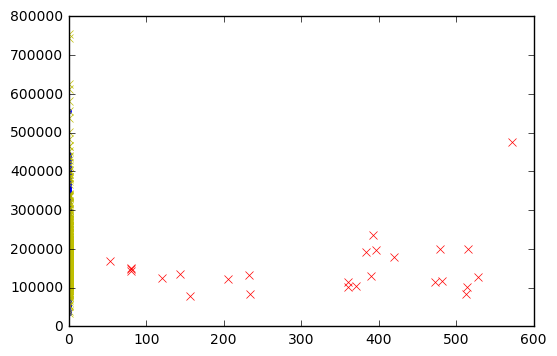

Feature GrLivArea has 4 outliers


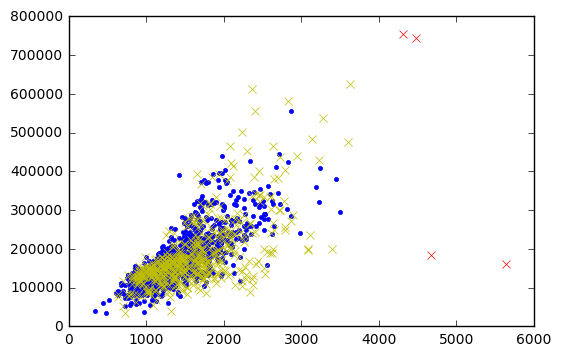

Feature BsmtFullBath has 1 outliers


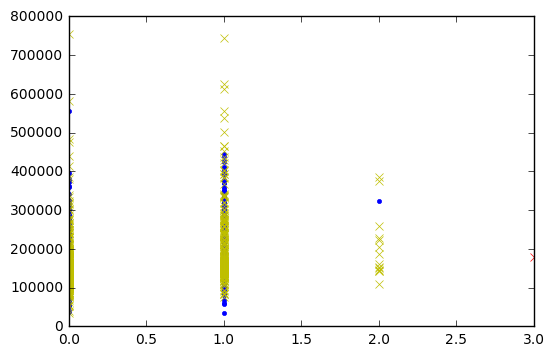

Feature BsmtHalfBath has 82 outliers


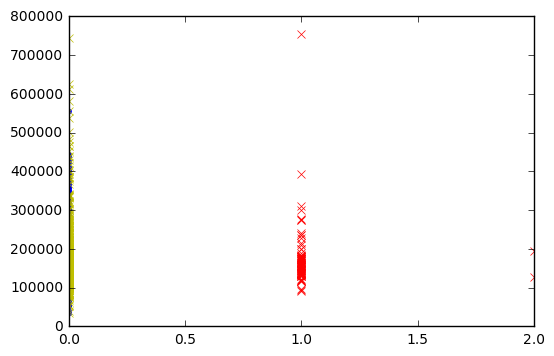

Feature FullBath has 0 outliers


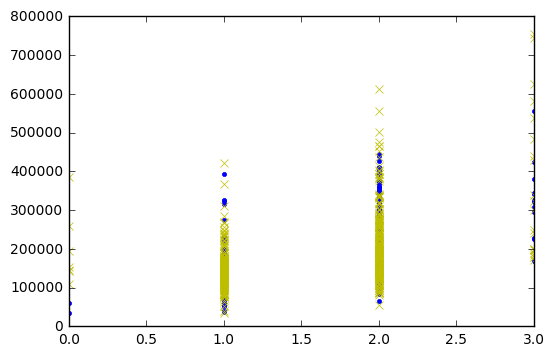

Feature HalfBath has 0 outliers


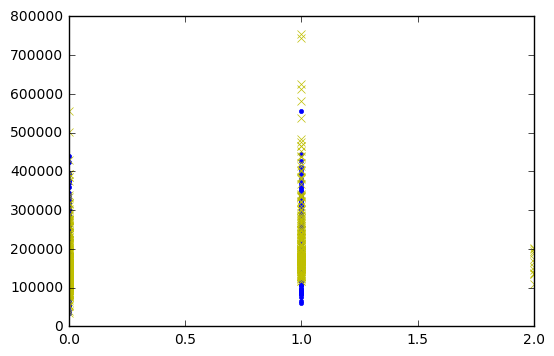

Feature BedroomAbvGr has 1 outliers


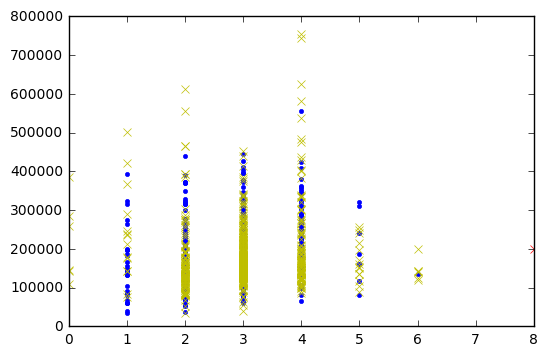

Feature KitchenAbvGr has 68 outliers


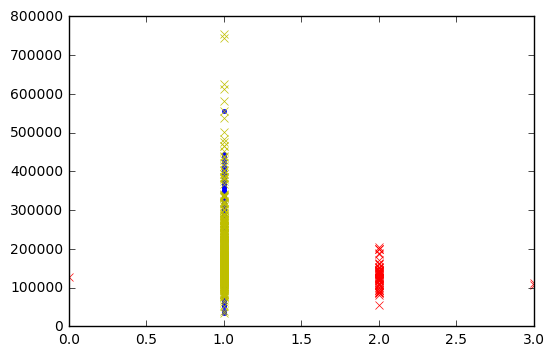

Feature TotRmsAbvGrd has 1 outliers


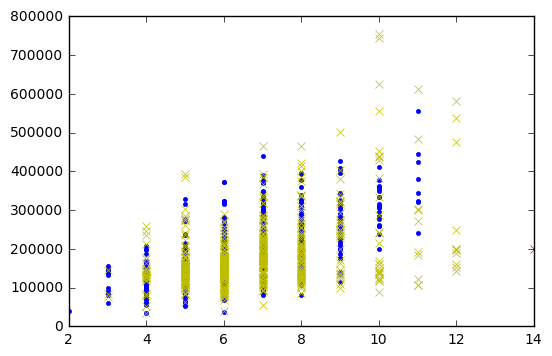

Feature Fireplaces has 0 outliers


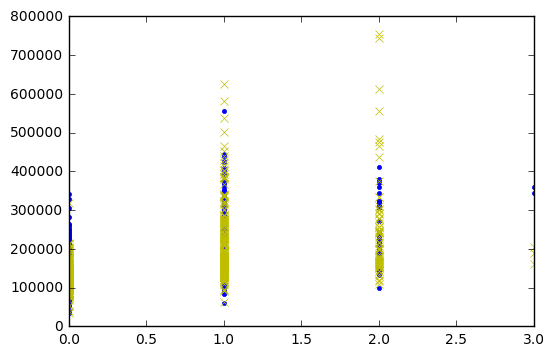

Feature GarageYrBlt has 0 outliers


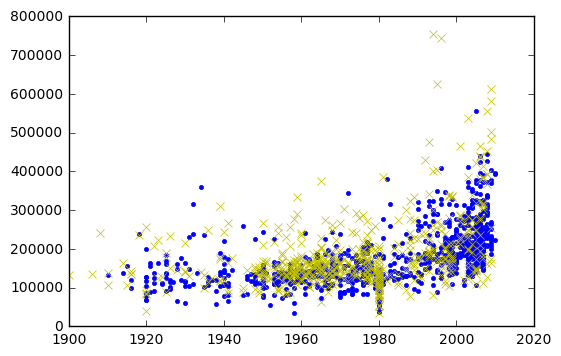

Feature GarageCars has 0 outliers


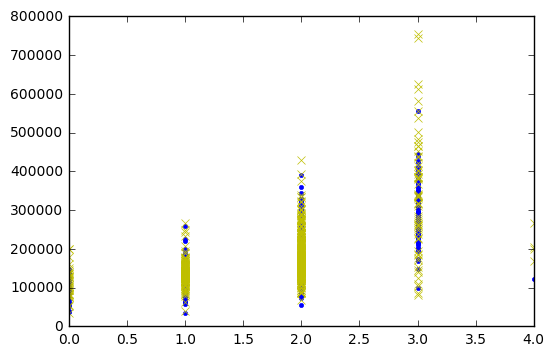

Feature GarageArea has 3 outliers


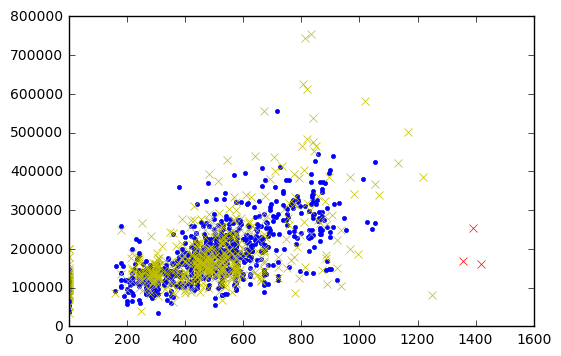

Feature WoodDeckSF has 5 outliers


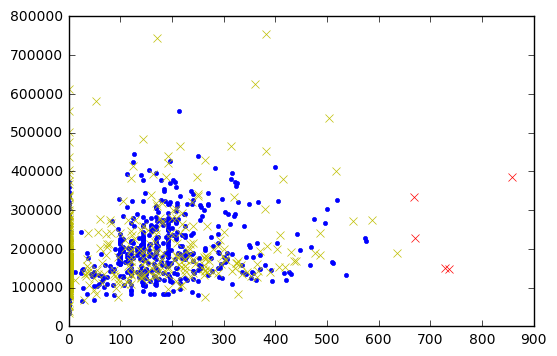

Feature OpenPorchSF has 55 outliers


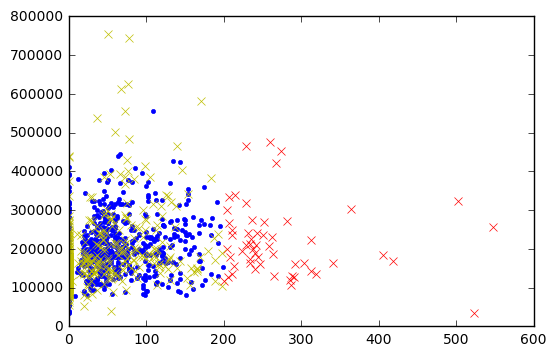

Feature EnclosedPorch has 99 outliers


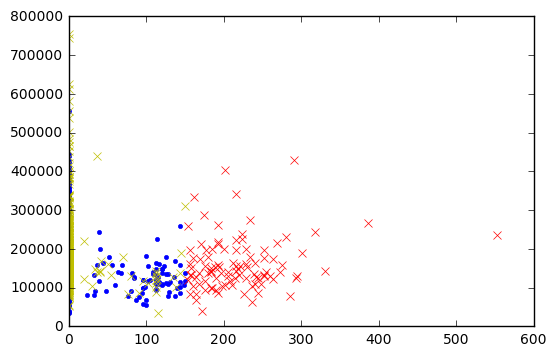

Feature 3SsnPorch has 23 outliers


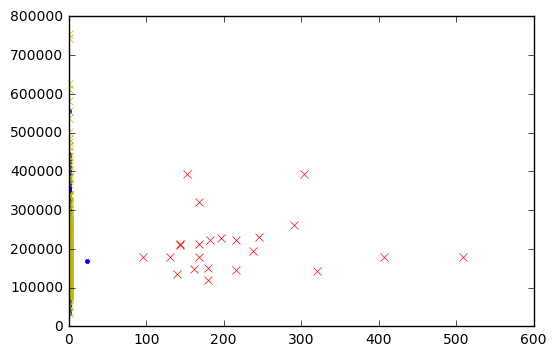

Feature ScreenPorch has 104 outliers


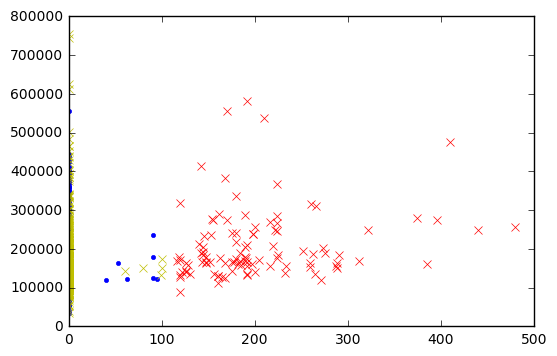

Feature PoolArea has 7 outliers


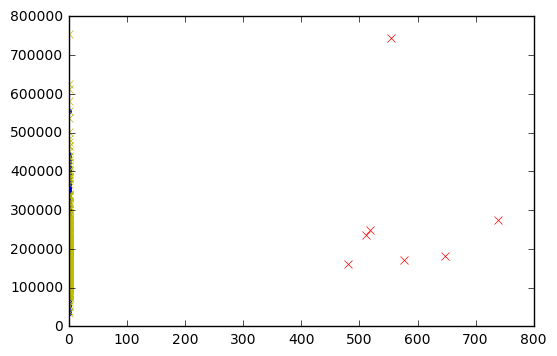

Feature MiscVal has 51 outliers


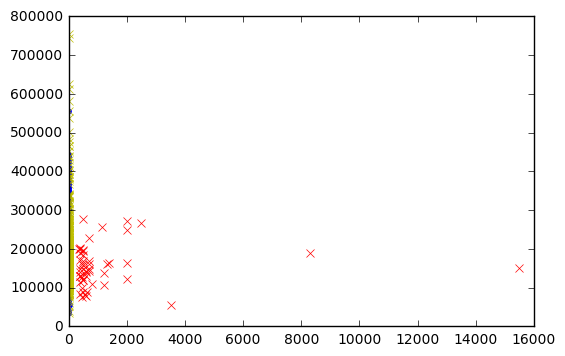

Feature MoSold has 0 outliers


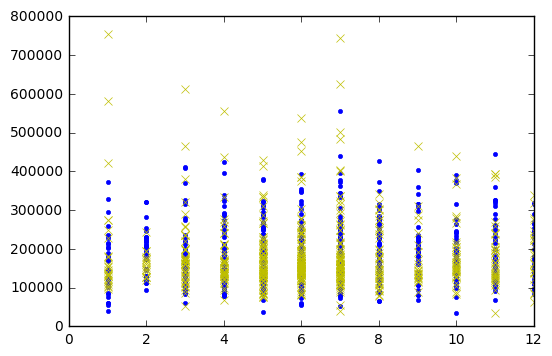

Feature YrSold has 0 outliers


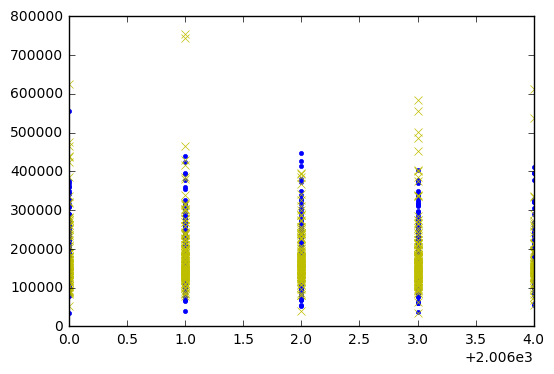

Feature TotLivSF has 5 outliers


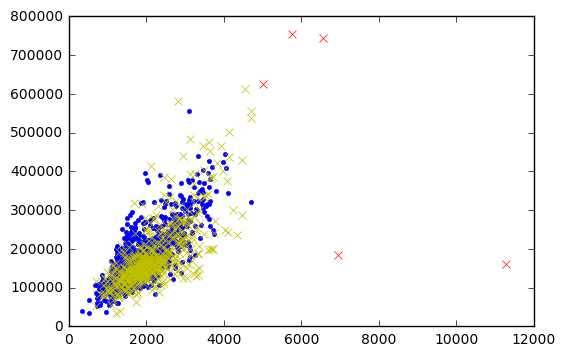

In [75]:
# Lets say more than 7*median away is an outlier...
m = 7
data_to_filter = ['train']

for k in data_to_filter:
    total_mask = np.array([False] * len(data[k].index))
    masks = {}
    
    # Filter only numerical features
    # Calculate masks
    for f in features['num']:
        masks[f] = outliers_numerical(data[k][f], m)
        total_mask = (total_mask) | (masks[f])

    # Visualize filtered data
    print("Total outliers = {}".format(total_mask.sum()))
    for f in features['num']:
        print("Feature {} has {} outliers".format(f, masks[f].sum()))
        
        good = ~total_mask
        bad_here = masks[f]
        bad_elsewhere = total_mask & ~bad_here
        
        plt.plot(data[k].loc[good, f], data[k].loc[good, 'SalePrice'], 'b.')
        plt.plot(data[k].loc[bad_here, f], data[k].loc[bad_here, 'SalePrice'], 'rx')
        plt.plot(data[k].loc[bad_elsewhere, f], data[k].loc[bad_elsewhere, 'SalePrice'], 'yx')
        plt.show()
        
    data[k] = data[k].loc[good, :]

A lot of good features are being removed here I think.  If I really wanted good results here, I'd look more deeply into these figures and pick and choose a few.  Some are entirely filtered after this, and a few are really categorical now that I look at them.

### Make new derived features (powers, sqrt, one-hot) 

**Notes:**
* First attempt here found that the train and test databases don't always have the entire set of categorical responses (eg: There is a single test MSSubClass=150 in test and none in train).  
* Currently avoiding this by addressing these inconsistencies in manual munging, but could also do some automated checks here

In [76]:
# Number of powers
p = 6
f_new = {'num': set(),
         'cat': set(),
        }

f_new['cat'] = {k:set() for k in data.keys()}

for f in features['num']:
    for k in data.keys():
        # Polynomials
        data[k], f_new_poly = feat_eng_polys(data[k], f, range(2, p), inplace=True)
        f_new['num'].update(f_new_poly)
        
        # Sqrt
        data[k].loc[:, f + '_0.5'] = np.sqrt(data[k].loc[:, f])
        f_new['num'].add(f + '_0.5')

# One-hot categoricals
for k in data.keys():
    for f in features['cat']:
        # Not sure if this is the best way to get the features, but using a temp variable to store the new features.
        # Could also get a set of data[k].columns before and after and take the difference
        temp =  pd.get_dummies(data[k][[f]], columns=[f])
        # Exclude the first column (redundant)
        f_new['cat'][k].update(list(temp.columns)[1:])
        data[k] = pd.concat([data[k], temp], axis=1)
        
# Update feature lists
features['num'] = sorted(features['num'] + list(f_new['num']))
print("Numerical features:")
print(features['num'])
# Remove the base names of the categorical features
features['cat'] = sorted(list(f_new['cat'][k]))
print("Categorical features:")
print(features['cat'])

Numerical features:
['1stFlrSF', '1stFlrSF_0.5', '1stFlrSF_2', '1stFlrSF_3', '1stFlrSF_4', '1stFlrSF_5', '2ndFlrSF', '2ndFlrSF_0.5', '2ndFlrSF_2', '2ndFlrSF_3', '2ndFlrSF_4', '2ndFlrSF_5', '3SsnPorch', '3SsnPorch_0.5', '3SsnPorch_2', '3SsnPorch_3', '3SsnPorch_4', '3SsnPorch_5', 'BedroomAbvGr', 'BedroomAbvGr_0.5', 'BedroomAbvGr_2', 'BedroomAbvGr_3', 'BedroomAbvGr_4', 'BedroomAbvGr_5', 'BsmtFinSF1', 'BsmtFinSF1_0.5', 'BsmtFinSF1_2', 'BsmtFinSF1_3', 'BsmtFinSF1_4', 'BsmtFinSF1_5', 'BsmtFinSF2', 'BsmtFinSF2_0.5', 'BsmtFinSF2_2', 'BsmtFinSF2_3', 'BsmtFinSF2_4', 'BsmtFinSF2_5', 'BsmtFullBath', 'BsmtFullBath_0.5', 'BsmtFullBath_2', 'BsmtFullBath_3', 'BsmtFullBath_4', 'BsmtFullBath_5', 'BsmtHalfBath', 'BsmtHalfBath_0.5', 'BsmtHalfBath_2', 'BsmtHalfBath_3', 'BsmtHalfBath_4', 'BsmtHalfBath_5', 'BsmtUnfSF', 'BsmtUnfSF_0.5', 'BsmtUnfSF_2', 'BsmtUnfSF_3', 'BsmtUnfSF_4', 'BsmtUnfSF_5', 'EnclosedPorch', 'EnclosedPorch_0.5', 'EnclosedPorch_2', 'EnclosedPorch_3', 'EnclosedPorch_4', 'EnclosedPorch_5', '

### Split the training data into training and validation sets to compare models

Still always confused when to do this and when not to.  If I use cross-validation, do I still need this?  I guess if I do CV and don't have this split, I have no way of knowing my typical error (as CV doesn't really give that)?

In [77]:
validation_size = 0.2
seed = 7
X_train, X_validation = model_selection.train_test_split(data['train'], test_size=validation_size, random_state=seed)
data['train'] = X_train
data['valid'] = X_validation

### Regress using several models

In [78]:
features_all = features['cat'] + features['num']

models = {
    'Linear': linear_model.LinearRegression(normalize=True),
    'Lasso': linear_model.Lasso(normalize=True, max_iter=10000),
    'LassoCV': linear_model.LassoCV(normalize=True, max_iter=10000, alphas=np.logspace(0, 3, 3*13+1)),
    'Ridge': linear_model.Ridge(normalize=True),
    'RidgeCV': linear_model.RidgeCV(normalize=True),
#     'SVM-Linear':   SVR(kernel='linear', C=1e3, gamma=0.1)
}

predictions = {}
results = {}

print("Evaluate using manual kfold cross validation")
print("{:10s}: {:6s}, ({:6s})".format('name', 'mean', 'std'))
for name, model in sorted(models.items()):
#     print(name, model)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, data['train'][features_all], data['train']['SalePrice'], cv=kfold)
    results[name] = cv_results
#     model.fit(data['train'][features_all], data['train'][['SalePrice']])
#     predictions[name] = model.predict(data['valid'][features_all])
    print("{:10s}: {:6.4f}, ({:6.4f})".format(name, cv_results.mean(), cv_results.std()))

Evaluate using manual kfold cross validation
name      : mean  , (std   )
Lasso     : 0.8810, (0.0409)
LassoCV   : 0.9108, (0.0250)
Linear    : -767915164030317004771431748206592.0000, (2303745487710074692962427374403584.0000)
Ridge     : 0.9072, (0.0276)
RidgeCV   : 0.9017, (0.0328)


I'm having strange behaviour from linear in a few places.  I think I'm using something incorrectly...

### Evaluate typical error for the models using the validation dataset, and make predictions for the test data

Results from before using 

    features = {'num': ["LotArea", "FullBath", "OverallQual"], #now using OverallQual as a number!
                'cat': ["MSSubClass", "Neighborhood"],
               }

Train on training database, then evaluate RMS on training and validation database

RidgeCV   : train     , valid     

Lasso     :   24566.89,   22474.41

LassoCV   :   24848.43,   23041.88

Linear    :   24404.00,   23579.76

Ridge     :   26714.39,   24358.31

RidgeCV   :   24854.10,   22692.25


SyntaxError: invalid syntax (<ipython-input-120-115704cb570a>, line 1)

In [150]:
def train_models(models, X, y, features=None):
    if features is None:
        features = X.columns
    for name,model in models.items():
        model.fit(X, y)
    return models

def predict_models(models, X_dict, features=None):
    predictions = {}
    for name, model in models.items():
        predictions[name] = {}
        for k,d in X_dict.items():
            if features is None:
                features_local = d.columns
            else:
                features_local = features
            predictions[name][k] = pd.DataFrame(model.predict(d[features_local]), columns=['SalePrice'], index=d.index)
    return predictions

def eval_predictions(predictions_dict, ref_dict):
    ret = {}
    for name, pred in predictions_dict.items():
        ret[name] = {}
        for d, ref in ref_dict.items():
#             print(ref['SalePrice'])
#             print(pred)
            ret[name][d] = np.sqrt(mean_squared_error(ref['SalePrice'], pred[d]['SalePrice']))
    return ret

In [155]:
models = train_models(models, data['train'][features_all], data['train']['SalePrice'])
predictions = predict_models(models, data, features=features_all)
pred_rms = eval_predictions(predictions, {'train': data['train'], 'valid': data['valid']})
print("Train on training database, then evaluate RMS on training and validation database")
print("{:10s}: {:>10s}, {:>10s}".format("name", 'train', 'valid'))

for name, model in sorted(models.items()):
    print("{:10s}: {:10.2f}, {:10.2f}".format(name, pred_rms[name]['train'], pred_rms[name]['valid']))

Train on training database, then evaluate RMS on training and validation database
name      :      train,      valid
Lasso     :   14292.96,   20302.54
LassoCV   :   17580.00,   17976.27
Linear    :   14161.78, 105518097553831696.00
Ridge     :   17706.50,   17808.70
RidgeCV   :   17706.50,   17808.70


Performance looks better here than when we had a ton of features.  That looks promising.  But the Linear model is F'd, any the Lasso model has a big difference between train and valid... overtraining indicator?

### Sanity checks on test predictions - we know the prices should all be positive and probably not THAT big

In [160]:
def find_obviously_stupid_results(models):
    for name,model in sorted(models.items()):
        print("Model: {}".format(name))
        below_zero = predictions[name]['test'][predictions[name]['test']['SalePrice'] < 0]
        above_1M = predictions[name]['test'][predictions[name]['test']['SalePrice'] > 1000000]
        print("Records below 0: {}".format(len(below_zero)))
        print("Records above 1000000: {}".format(len(above_1M)))
        print("\n")
        #     print(below_zero)
        #     print("{:15s}: {}")
    #     print(len(predictions[name]['test']))
find_obviously_stupid_results(models)

Model: Lasso
Records below 0: 166
Records above 1000000: 40


Model: LassoCV
Records below 0: 48
Records above 1000000: 0


Model: Linear
Records below 0: 159
Records above 1000000: 228


Model: Ridge
Records below 0: 137
Records above 1000000: 1


Model: RidgeCV
Records below 0: 137
Records above 1000000: 1




**But there are A TON of negatives!!  So is this indicating overtraining?  Or some other source of high variance error.  So what do I do to fix this?**

Gut says that I've got bad features in here.  But I'd have thought Lasso inherrently would remove those through the CV process.  Maybe this is why more rigorous feature selection/preprocessing is necessary?

Out of curiosity, lets still export LassoCV and see how it compares to the last one.  For anything negative, fill it in with the mean from the training data.

In [85]:
data['train']['SalePrice'].mean()

179451.45788043478

In [86]:
predictions['LassoCV']['test'].loc[predictions['LassoCV']['test']['SalePrice'] < 0, 'SalePrice'] = data['train']['SalePrice'].mean()

Export predictions of a few models

In [88]:
# Commented out so I dont keep overwriting the thing...
# predictions['LassoCV']['test'].to_csv('test_predictions_all_features-1_LassoCV.csv')
# -> Private score: 0.19665.  Public score: 0.15575

So it was a little worse than LassoCV on the couple of features from before, but not as terrible as it seemed.  It is tough though, because if I just trusted the scores from the cross-validation above it would suggest this should be WAY better than the few-feature attempt. 

In [178]:
# Use Ridge regression model to make a recursive feature extraction
# Not sure if I should use RidgeCV or just Ridge.  Is there something bad about using RidgeCV here?  
# RidgeCV yielded slightly better RMS on some models and worse on others...
rfecv = RFECV(linear_model.RidgeCV(normalize=True))
rfecv.fit(data['train'][features_all], data['train']['SalePrice'])

RFECV(cv=None,
   estimator=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [167]:
print("Total number of features available: {}".format(len(features_all)))
print("Features selected as useful by RFECV: {}".format(rfecv.support_.sum()))


Total number of features available: 396
Features selected as useful by RFECV: 327


Inspect the removed features:

In [173]:
features_rfecv = [features_all[i] for i in range(len(features_all)) if rfecv.get_support()[i]]
excluded = [(features_all[i], rfecv.ranking_[i]) for i in range(len(features_all)) if not rfecv.get_support()[i]]
# pprint.pprint(list(zip(features_all, rfecv.ranking_)))
pprint.pprint(excluded)

[('1stFlrSF_3', 5),
 ('1stFlrSF_4', 27),
 ('1stFlrSF_5', 42),
 ('2ndFlrSF_3', 2),
 ('2ndFlrSF_4', 22),
 ('2ndFlrSF_5', 39),
 ('BsmtFinSF1_4', 18),
 ('BsmtFinSF1_5', 35),
 ('BsmtFinSF2_4', 9),
 ('BsmtFinSF2_5', 20),
 ('BsmtHalfBath', 58),
 ('BsmtHalfBath_0.5', 51),
 ('BsmtHalfBath_2', 63),
 ('BsmtHalfBath_3', 53),
 ('BsmtHalfBath_4', 55),
 ('BsmtHalfBath_5', 66),
 ('BsmtUnfSF_3', 7),
 ('BsmtUnfSF_4', 25),
 ('BsmtUnfSF_5', 37),
 ('EnclosedPorch_5', 11),
 ('GarageArea_4', 15),
 ('GarageArea_5', 33),
 ('GarageYrBlt_3', 4),
 ('GarageYrBlt_4', 26),
 ('GarageYrBlt_5', 41),
 ('GrLivArea_3', 8),
 ('GrLivArea_4', 28),
 ('GrLivArea_5', 43),
 ('KitchenAbvGr', 48),
 ('KitchenAbvGr_0.5', 60),
 ('KitchenAbvGr_2', 49),
 ('KitchenAbvGr_3', 69),
 ('KitchenAbvGr_4', 56),
 ('KitchenAbvGr_5', 47),
 ('LotArea_3', 30),
 ('LotArea_4', 44),
 ('LotArea_5', 46),
 ('LotFrontage_5', 24),
 ('LowQualFinSF', 70),
 ('LowQualFinSF_0.5', 62),
 ('LowQualFinSF_2', 59),
 ('LowQualFinSF_3', 61),
 ('LowQualFinSF_4', 52),
 ('

21 of the 37 numeric columns had at least the data^5 polynomial rejected, and many others with data^4.  There are also several that were rejected entirely.  

No categoricals were rejected, which is interesting.  Not sure why.

### Try fitting using only the features from the rfecv selection


['Alley_Pave', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'CentralAir_Y', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_TA', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', '

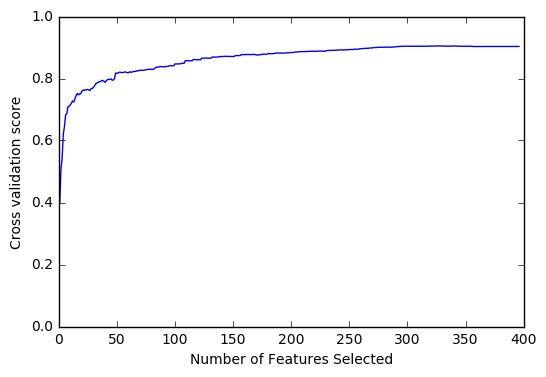

In [174]:
rfecv.support_
rfecv_features = [features_all[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]
print(rfecv_features)
plt.figure()
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross validation score")
plt.ylim((0, 1))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)


In [175]:
len(features_rfecv)

327

In [176]:
models = train_models(models, data['train'][features_rfecv], data['train']['SalePrice'])
predictions = predict_models(models, data, features=features_rfecv)
pred_rms = eval_predictions(predictions, {'train': data['train'], 'valid': data['valid']})
print("Train on training database, then evaluate RMS on training and validation database")
print("{:10s}: {:>10s}, {:>10s}".format("name", 'train', 'valid'))

for name, model in sorted(models.items()):
    print("{:10s}: {:10.2f}, {:10.2f}".format(name, pred_rms[name]['train'], pred_rms[name]['valid']))

Train on training database, then evaluate RMS on training and validation database
name      :      train,      valid
Lasso     :   14567.51,   19057.71
LassoCV   :   17662.27,   17936.21
Linear    :   13800.42, 36200018222023912.00
Ridge     :   18079.79,   18431.62
RidgeCV   :   18079.79,   18431.62


Train on training database, then evaluate RMS on training and validation database
name      :      train,      valid
Lasso     :   14418.50,   19510.42
LassoCV   :   17598.87,   18072.40
Linear    :   13446.14, 17462108331457308.00
Ridge     :   17851.53,   18078.98
RidgeCV   :   17851.53,   18078.98

These are a mixed bag compared to above.  Some better, some worse.  

Lets look at the obviously wrong predictions like above:

In [177]:
find_obviously_stupid_results(models)

Model: Lasso
Records below 0: 120
Records above 1000000: 9


Model: LassoCV
Records below 0: 48
Records above 1000000: 0


Model: Linear
Records below 0: 273
Records above 1000000: 95


Model: Ridge
Records below 0: 103
Records above 1000000: 0


Model: RidgeCV
Records below 0: 103
Records above 1000000: 0




Try LassoCV on the 

In [180]:
# Commented out so I dont keep overwriting the thing...
# predictions['LassoCV']['test'].loc[predictions['LassoCV']['test']['SalePrice'] < 0, 'SalePrice'] = data['train']['SalePrice'].mean()
# Output when using Ridge for RFECV
# predictions['LassoCV']['test'].to_csv('test_predictions_all_features-2_LassoCV.csv')
# -> Private score: 0.19652.  Public score: 0.15610
# Output when using RidgeCV for RFECV
# predictions['LassoCV']['test'].to_csv('test_predictions_all_features-3_LassoCV.csv')
# -> Private score: 0.18285.  Public score: 0.15495

**Basically the same as the above results when using Ridge in RFECV, and a bit better when using RidgeCV in RFECV**

I guess that says that RFECV->LassoCV and LassoCV alone filter out about the same features?  That is also in line with the RMS errors that were predicted on train and valid between the two attempts...

## Next Steps
* Add LassoCV, then take LassoCV's selected features and fit them with RidgeCV.  How does that compare to feature selection's RidgeCV?


* Redo everything but normalize the data first.  
    * Does this improve results?
    * Does this make LinearRegression work with feature selection?
* Systematic filtering 
    * Systematic skewness adjustment (see bookmarks)
    * see bookmarks, and look at the sklearn feature_selection man page
    * RFECV or RFE (which gives you N best)
    * Principal Component Analysis (PCA).  See http://machinelearningmastery.com/feature-selection-machine-learning-python/, http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/
    * Stability Selection using randomized lasso or other (http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/) **Good breakdown of pros/cons of different methods!!**
    * As shown in above ref, could always use something like basic linear correlation to find influencial features (but possibly correlated ones), then something else like Lasso or RFECV others to choose between them.   
* Use sklearn.preprocessing.PolynomialFeatures instead of my own (?)

* Get SVR to work.